# CS146 Project 2: Discrete and multi-level models

Here is a data set of kelp plant counts near the coast. The coastal area was divided into 100 20 m × 20 m grid squares and the number of kelp was painstakingly counted in each grid square. Unfortunately, some of the grid squares were not counted.

Your task is to fit an appropriate discrete count model for this data set and to estimate the number of kelp in the missing cells.

Prior knowledge: We expect something like 0 to 2 kelp plants per square meter. Note: Each grid square has an area of 400 m².

## Data

The integer values below are the recorded kelp counts. There are some `nan` values where we have missing data. The missing data show up as white squares in the plot below.

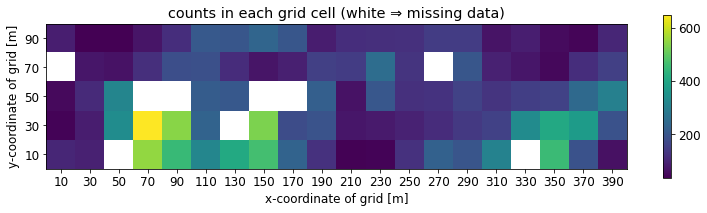

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

## Required tasks

1. Come up with a strategy for estimating the values of the missing cells. How can you use the cell values you have to estimate/predict the values of the cells you don’t have? Describe your strategy to the client.
2. Implement two Poisson models to produce the predictions for the missing cells.
  1. Complete pooling. Assume the counts are generated i.i.d. from a Poisson distribution with an unknown rate parameter. Compute the posterior distribution over the rate parameter and make predictions using this posterior distribution.
  2. Partial pooling. Assume a hierarchical/multi-level model where each grid cell has a Poisson distribution with its own rate parater but the rate parameters come from a common prior with unknown parameters. Choose the prior appropriately. Compute the posterior distribution over all the rate parameters and the parameters of your chosen prior and make predictions using this posterior distribution.
3. Explain or demonstrate how you came up with your prior distributions for the two models.
4. Show the predictions of the values of each missing cell. Explain the differences between the predictions of the complete pooling and partial pooling models. You will find that one model is more confident (has less variance in its predictions) than the other model. Explain which model we should prefer.

# The Strategy
To estimate the values of the missing cells, we will build two Bayesian models. Each will use the data that we have about the proportion of kelp in a grid cell to provide an estimate of how much kelp is in the uncounted grid squares. In both cases, we'll assume that the kelp counts are sampled from a Poisson distribution with rate $\lambda$. This means that we're assuming that the amount of kelp per grid cell is, on average, $\lambda$. 

Our first approach will be a "complete pooling" approach. Here, we assume that the kelp counts are all sampled from the same distribution; that each grid cell is the same and that variation in the number of kelp in each cell is purely stochastic. To infer the number of kelp in the unmeasured cells, we'll sample from the distribution we estimate from the measured cells. 

The second approach uses "partial pooling." Here, we no longer assume that each cell has the same expected number of kelp, and instead estimate a unique rate parameter $\lambda_i$ for each cell. At the same time, we assume that those $\lambda_i$s are described by an overarching distribution (the hyperprior); the model will learn both about the unique rate parameters for each cell, and the sample-level rate parameter across all of the cells. We'll use that higher level to make inferences about the unknown cells, since we have no other information about them. 

want to add something about how pooling lets us learn about each cell and the overarching pattern

# Model 1: Complete pooling
The goal in all three models is to confidently interpolate the missing values. In model 1, we model the kelp counts as all being pulled from the same Poisson distribution with rate parameter $\lambda$. The Poisson distribution models the expected number of times something will occur when it occurs at a mean rate $\lambda$. In our case, we're considering the number of kelp per cell, knowing that the base rate is somewhere between 0 and 2 kelp per square metre. The complete pooling model is defined as follows. Each piece is justified subsequently. 
$$\begin{align*}
    k_i &\sim \text{Poisson}(\lambda)\\
    \log(\lambda) &= 400\alpha\\
    \alpha &\sim \text{Normal}(\mu=0,\sigma^2=1)
\end{align*}$$

$k_i$ is the number of kelp per cell. As previously justified, it is a Poisson process. Our goal is to estimate $\lambda$, the number of kelp per cell, which is determined by $\alpha$, the number of kelp in a square metre. Our prior belief is that the number of kelp per square metre is between 0 and 2, and this Normal(0,2) distribution places 99% of its probability mass between -2 and 2. More on that momentarily. The link function for a Poisson distribution should have a strictly positive range (a negative $\lambda$ is nonsenscial), and this is ensured by the log function. Note that since our prior is on the number of kelp per square meter, and a cell is 400 m$^2$, we also multiply by 400. Because the link function is defined on $(-\infty, \infty)$ but outputs on $[0,\infty)$, both positive and negative $\alpha$ map to positive $\lambda$ through the linker. Thus the prior on $\alpha$ reflects our belief about the number of kelp per square meter despite being centered at 0. 


In [373]:
#importing the relevant packages 
import pymc as pm
import scipy.stats as sts 
import arviz as az 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random

In [24]:
#preparing the data 
#puttin the data into a dataframe 

#indices refer to a unique cell. k is the number of kelp per cell. 
df = pd.DataFrame(data.flatten(), columns = ['k']) 

#we don't want any nan values as we build our model
df_nona = df.dropna().reset_index()

In [217]:
#implementing the first model 
n_samples = 2000
cell_size = 400
with pm.Model() as m1: 
    a = pm.Normal('a', mu = 0, sigma = 1) #prior 
    log = pm.math.exp(a)*cell_size
    lam = pm.Deterministic('lam', log)
    k_i = pm.Poisson('ki', mu = lam, observed = df_nona)
    #sampling the model 
    trace_m1 = pm.sample(n_samples, idata_kwargs = {'log_likelihood':True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


Sampling: [a, ki]


95% HDI: [ 10 , 2073 ]
Expected number of kelp:  652.127282967033


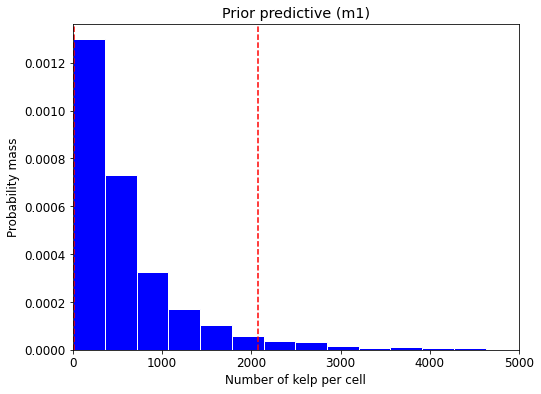

In [219]:
#prior predictive
with m1:
    prior_pred_1 = pm.sample_prior_predictive(n_samples)

prior_pred_1

#plotting the prior predictive
ks = prior_pred_1.prior_predictive.ki.values.flatten()
CI = az.hdi(ks, hdi_prob=.95)
print('95% HDI: [', CI[0], ',', CI[1], ']')
print('Expected number of kelp: ', ks.mean())
plt.figure(figsize = (8,6))
plt.hist(ks, bins = 50, color = 'b', edgecolor = 'white', density = True)
plt.axvline(CI[0], color = 'r', linestyle = '--')
plt.axvline(CI[1], color = 'r', linestyle = '--')
plt.xlabel('Number of kelp per cell')
plt.ylabel('Probability mass')
plt.xlim(-0.5,5000)
plt.title('Prior predictive (m1)')
plt.show()

The output above shows the prior predictive distribution over the number of kelp in a cell. The 95% HDI is between 0 and 2021 kelp per cell. The prior-predictive matches our prior belief in that we believe that there are typically between 0 and 2 kelp per square meter, or between 0 and 800 kelp in a cell. The prior predictive allows for these values, and also much more extreme ones. This is useful as it does not completely eliminate the possibility of more extreme values than is our belief. The expected number of kelp under the prior distribution is about 650, or 1.625 kelp per square meter, which matches our belief that this rate is somewhere between 0 and 2. 

## Diagnostics

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.242,0.007,-1.255,-1.229,0.000,0.00,3099.0,5584.0,1.0
lam,115.495,0.804,113.999,117.044,0.014,0.01,3099.0,5584.0,1.0


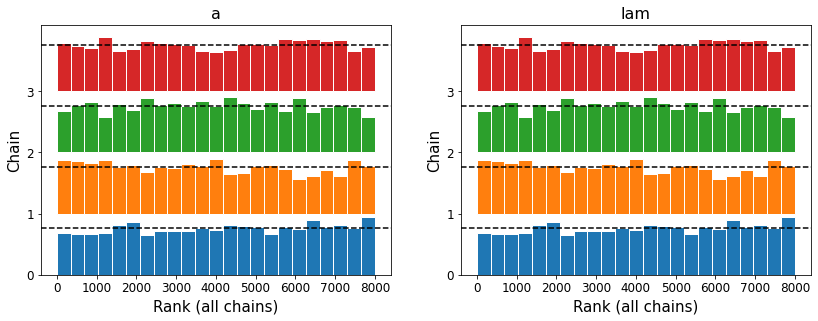

In [28]:
#diagnostics
az.plot_rank(trace_m1)
az.summary(trace_m1)

The purpose of the above cell is to verify that the algorithm that samples the posterior distribution did so successfully. Let's first focus on the rank plots. We can only be confident in our model's inferences if all the chains that sampled the posterior converged. If this is the case, then the rank plots for each chain should appear uniform and the same. This seems to generally be the case. Note some poor mixing in chain 3 for both $\alpha$ and $\lambda$. There is a minor deviation from the ideal uniform distribution in these chains, though this isn't noticable in any other chains and it is likely that the posterior was still successfully explored. 

The $\hat{R}$ and ESS statistics both support successful convergence. Convergent chains should have minimal between chain variance. As this variance tends to 0, $\hat{R}\rightarrow 1$. With $\hat{R} = 1.00$ for both parameters, the chains have low between-chain variance. Similarly, the effective sample size provides a measure of the number of independent samples. A minimum ESS is 10% of the number of samples, which m1 vastly exceeds. This suggests that samples in a chain were typically independent. Together, the diagnostic statistics and rank plots suggest that he posterior was successfully sampled.

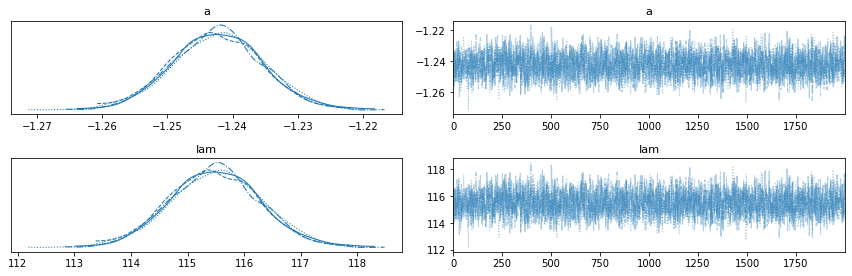

In [220]:
#plotting the posterior 
az.plot_trace(trace_m1)
plt.tight_layout()

The plot above shows the posterior ditribution over $\alpha$ and $\lambda$. Both traces are approximately normal. As we're mainly concerned with the number of kelp per cell ($\lambda$) and not the number per square meter ($\alpha$), let's focus only on the bottom trace. We see an approximately normal shape centere about 115.5. The distribution is quite narrow considering the range of the data, and the main takeaway is that m1 predicts that the number of kelp in the average cell likely sits between 113 and 118. 

Sampling: [ki]


95% confidence interval: [ 95.0 ,  137.0 ]


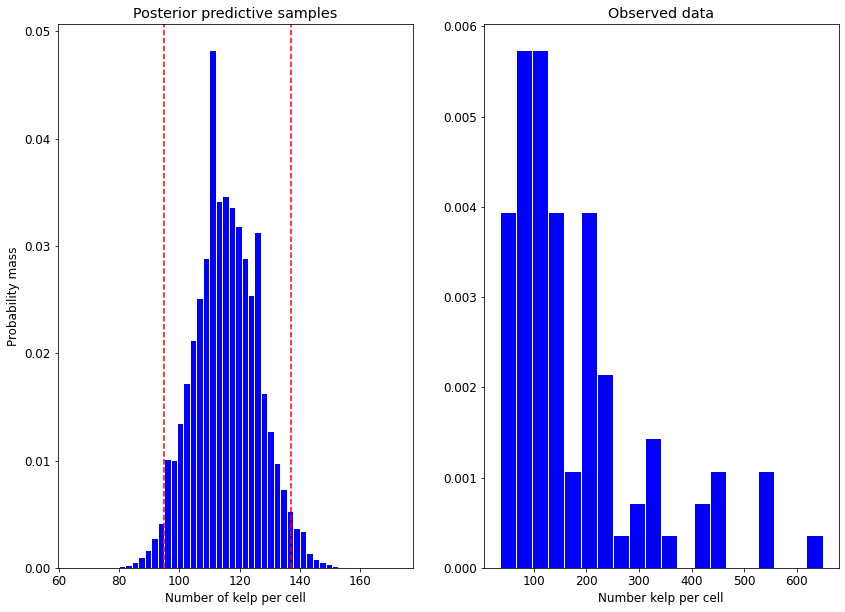

In [221]:
#sampling and plotting the posterior_predictive 
with m1: 
    pm.sample_posterior_predictive(trace_m1, extend_inferencedata = True)
plt.subplots(1,2,figsize = (14,10))

k_pred = trace_m1.posterior_predictive.ki.values.flatten()
plt.subplot(1,2,1)
CI = np.quantile(k_pred, (0.025, 0.975))
print('95% confidence interval: [', CI[0], ', ', CI[1],']')
plt.hist(k_pred, bins = 50, color = 'b', edgecolor = 'white', density = True)
plt.axvline(CI[0], color = 'red', linestyle = '--')
plt.axvline(CI[1], color = 'red', linestyle = '--')
plt.xlabel('Number of kelp per cell')
plt.ylabel('Probability mass')
plt.title('Posterior predictive samples')

plt.subplot(1,2,2)
plt.hist(df_nona.k.values, bins = 20, color = 'b', edgecolor = 'white', density = True)
plt.xlabel('Number kelp per cell')
plt.title('Observed data')
plt.show()


The posterior-predictive distribution and the data are displayed in the output above. For our model to be a good fit to the data generating process, it should plausibly predict the data. This is not the case. The posterior-predictive predicts that 95% of cells will be contain between 95 and 137 kelp, and that none will have more than 160. However, much of the actual cells contain upwards of 200 kelp, some as many as 600. Under m1, such data are extremely unlikely to be generated. This mismatch between posterior-predictive and observed data is a sign that m1 is a poor fit to the data. We will improve on it with m2 and m3. 

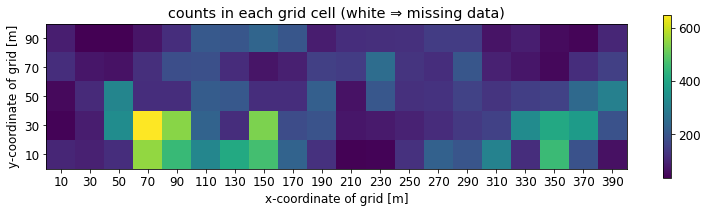

In [51]:
#using this model to interpolate the missing points      
def interpolate_complete_pooling(trace, df):
    copy = df.copy()
    nan_indxs = copy.loc[pd.isna(copy["k"]), :].index
    loop = nan_indxs.to_list()
    #interpolating each point
    for i in loop:
        lam_mean = np.mean(trace_m1.posterior.lam.values.flatten())
        copy.at[i, 'k'] = lam_mean
    return copy
interpolated_m1 = interpolate_complete_pooling(trace_m1, df)

#updating na values

#first we get their indices in the df and data objects 
nan_arr_indxs = np.argwhere(np.isnan(data))
nan_df_indxs = df.loc[pd.isna(df["k"]), :].index

#now we update the nan values in the list using the corresponding inferred value in interpolated

#making a copy of the data 
data_m1_interpolated = data.copy()
for arr_idx, nan_df_indx in zip(nan_arr_indxs, nan_df_indxs):
    data_m1_interpolated[arr_idx[0],arr_idx[1]] = interpolated_m1.at[nan_df_indx, 'k']
    
#finally generating the plot
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_m1_interpolated, origin='lower')
plt.xticks(np.arange(data_m1_interpolated.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_m1_interpolated.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()
        

Finally, we use m1 to interpolate the missing points. The interpolated points are all purple, as is expected from the posterior-predictive, irrespective of their location on the grid. The predictions given by m1 are rather uninformative as they assume that the cells to be interpolated are similar to the mean cell, an assumpion that mightn't be true.

# Model 2: Partial pooling 
Model 2 improves upon model 1 by removing the assumption that all counting cells are identical. It assumes that the kelp counts in each cell $k_i$ are generated from a Poisson distribution with a rate parameter $\lambda_i$; each cell may have a different $\lambda_i$. It additionally assumes that those $\lambda_i$s are described by an overarching hyper-distribution. Such a model accounts for commonality between cells by pooling the data into hyperparameters, while also allowing for additional variation within cells by estimating the $\lambda_i$ for each cell, rather than a single population level $\hat{\lambda}$. 

The model is defined as follows: 
$$
\begin{align*}
    k_i &\sim \text{Poisson}(\lambda_i)\\
    \ln(\lambda_i) &= \alpha_{\text{CELL}_{[i]}} \ln(400)\\
    \alpha_j &\sim \text{Normal}(\bar{\alpha},\sigma_\alpha)\\
    \bar{\alpha} &\sim \text{Normal}(0,1)\\
    \sigma_\alpha &\sim \text{Exponential}(2)
\end{align*}
$$
This model is similar to m1, except that we now estimate an individual rate $\lambda_i$ in each cell. These are modeled via the log link function, and the prior on the intercept is still Normal, except we now have hyperpriors for this distribution. Our belief about the mean cell has not changed, so we still used a Normal(0,1) prior for the number of kelp per square meter, except that this is now the prior over $\bar{\alpha}$ rather than $\alpha_j$; each individual cell may have a higher or lower expected number of kelp per square meter, but the average one contains between 0 and 2. As models with partial pooling are subject to overfitting, especially with broad, uninformative priors, we place a regularising prior over $\sigma_\alpha$ to allow for some variation in $\alpha_j$. Note that because of the log link, small variation in $\alpha_j$ can produce large variation in $\lambda_i$. An Exponential(1) prior would allow $\sigma_\alpha$ to take on integer values >2, whereas the Exponential(2) prior assigns very low probabilities to such high values of $\sigma_\alpha$ relative to the expected number of kelp per cell, and is therefore a tighter and more regularising prior. 




In [32]:
ncells = df_nona.shape[0]
cell = np.arange(df_nona.shape[0])
#make the cell cluster variable


#define the model 
with pm.Model() as m2: 
    #hyperpriors
    a_bar = pm.Normal('a_bar',0,1)
    sigma_a = pm.Exponential('sigma_a', 2)
    
    #prior
    alpha_j = pm.Normal('alpha_j', mu = a_bar, sigma = sigma_a, shape = ncells)
    
    #link function 
    lam = pm.math.exp(alpha_j[cell])*400
    
    #likelihood
    k = pm.Poisson('k', lam, observed = df_nona['k'])
    
    #sampling the posterior 
    trace_m2 = pm.sample(n_samples,idata_kwargs = {'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, alpha_j]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_bar       -1.018  0.071  -1.153   -0.885      0.001    0.000   12794.0   
alpha_j[0]  -1.374  0.098  -1.556   -1.192      0.001    0.001   13695.0   
alpha_j[1]  -1.463  0.102  -1.657   -1.279      0.001    0.001   15059.0   
alpha_j[2]   0.312  0.044   0.230    0.394      0.000    0.000   13590.0   
alpha_j[3]   0.111  0.047   0.022    0.198      0.000    0.000   16759.0   
...            ...    ...     ...      ...        ...      ...       ...   
alpha_j[87] -1.517  0.105  -1.718   -1.325      0.001    0.001   11638.0   
alpha_j[88] -1.973  0.135  -2.217   -1.715      0.001    0.001   14806.0   
alpha_j[89] -2.164  0.148  -2.448   -1.890      0.001    0.001   13904.0   
alpha_j[90] -1.373  0.097  -1.551   -1.185      0.001    0.001   14377.0   
sigma_a      0.683  0.053   0.589    0.784      0.000    0.000   12815.0   

             ess_tail  r_hat  
a_bar          5599.0    1.0  
alpha_j[0]     6127.0    

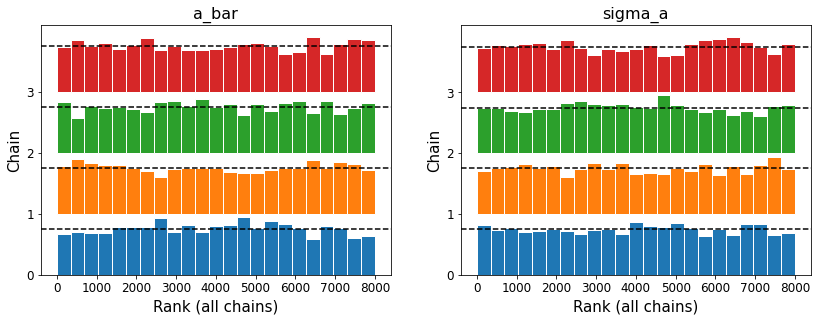

In [222]:
#diagnostics
varnames = ['~alpha_j']
az.plot_rank(trace_m2, var_names = varnames)
print(az.summary(trace_m2))

Rank plots are produced for the hyperparameters, and the parameters for which either ESS or $\hat{R}$ were dissatisfactory are presented above. There are no such parameters! With all the parameters having $\hat{R} \leq 1.01$ and satisfactory ESS values, this provides a good case that the MCMC chains converged successfully. The rank plots over the hyperparameters, which can sometimes be problematic in hierarchichal models, show successful convergence: we see nice, uniform rank plots across all chains for both $\bar{\alpha}$ and $\sigma_\alpha$.

$E[\bar{\alpha}] = $ -1.0181761896632078
$E[\sigma_\alpha] = $ 0.6827558580543197


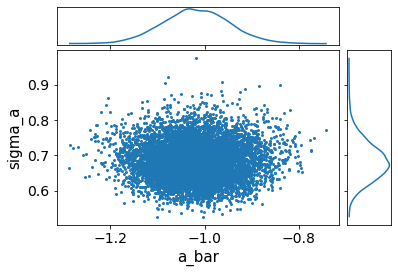

In [375]:
az.plot_pair(trace_m2, var_names = ['~alpha_j'], marginals = True)
print(r'$E[\bar{\alpha}] = $', trace_m2.posterior.a_bar.values.flatten().mean())
print(r'$E[\sigma_\alpha] = $', trace_m2.posterior.sigma_a.values.flatten().mean())

The pair plot gives us a sanity check that the posterior looks as expected. For our hyperparameters, they should be approximately normally distributed, and indeed we see the expected elliptical shape. The posterior over $\bar{\alpha}$ is normal and centered on -1.0; the expected number of kelp in an average cell (or a cell we know nothing about) is 147.5. This is consistent with our beliefs with partial pooling. Looking at $\sigma_\alpha$, it is approximately normally distributed about a mean of $\approx 0.68$. This means that the average number of kelp per square meter, deviates from $\bar{\alpha}$, by 0.68 kelp per square meter. This is a pretty big deviation: $\pm 272$ kelp per cell! We see that there is still wide variation between cells, and this is well captured by the rather broad posterior over $\sigma_\alpha$.

Sampling: [k]


95% confidence interval: [ 38.0 543.0 ]


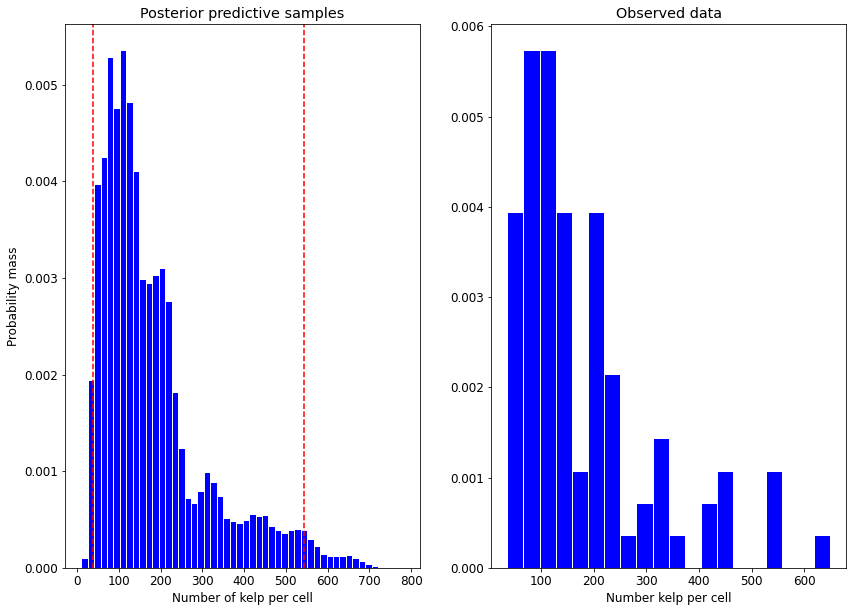

In [229]:
#sampling the posterior predictive
with m2: 
    pm.sample_posterior_predictive(trace_m2, extend_inferencedata = True)
plt.subplots(1,2,figsize = (14,10))
k_pred = trace_m2.posterior_predictive.k.values.flatten()
CI = np.quantile(k_pred, (0.025, 0.975))
plt.subplot(1,2,1)

#plotting the posterior predictive
print('95% confidence interval: [', CI[0], CI[1], ']')
plt.hist(k_pred, bins = 50, color = 'b', edgecolor = 'white', density = True)
plt.axvline(CI[0], color = 'red', linestyle = '--')
plt.axvline(CI[1], color = 'red', linestyle = '--')
plt.xlabel('Number of kelp per cell')
plt.ylabel('Probability mass')
plt.title('Posterior predictive samples')

#plotting the true samples
plt.subplot(1,2,2)
plt.hist(df_nona.k.values, bins = 20, color = 'b', edgecolor = 'white', density = True)
plt.xlabel('Number kelp per cell')
plt.title('Observed data')
plt.show()


Comparing the posterior predictive and true data distribution, we see that model 2 is much more compelling than model 1. There is a strong right skew, and most of the probability density sits below 250 kelp per cell. However, there is now a long tail, and the 95% confidence interval is wider than predicted by m1. Importantly, m2 predicts much higher kelp counts than m1, and the data somewhat resembles the posterior-predictive. This is a huge improvement over m1. 

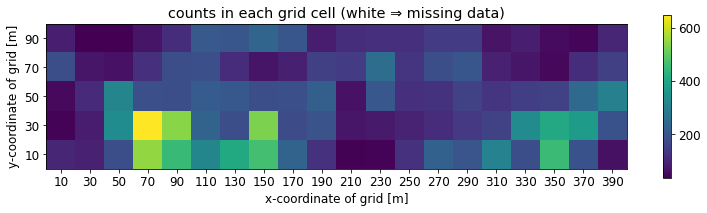

In [153]:
#interpolating values using the partial poolong model 

def interpolate_partial_pooling(trace, df):
    copy = df.copy()
    nan_indxs = copy.loc[pd.isna(copy["k"]), :].index
    loop = nan_indxs.to_list()
    lams_i = []
    #interpolating each point
    for i in loop:
        #the code in this loop is adapted from code 13.8 from Session 17 
        #we fill the cell with its expected number of kelp (λ)
        #this is simply a_sim log transformed 
        #we don't know anything about the cells to be interpolated so rely on the population 
        #level hyperparameters 
        a_sim = np.random.normal(loc=trace.posterior.a_bar, 
                                 scale=trace.posterior.sigma_a)       
        lam_raw_asim = np.exp(a_sim[:, :, None])
        lams_i.append(list(lam_raw_asim.flatten()*400))
        #updating the nan value
        copy.at[i, 'k'] = lam_raw_asim.mean()*400
    return lams_i, copy
interpolated_m2 = interpolate_partial_pooling(trace_m2, df)[1]
interpolated_m2_full = interpolate_partial_pooling(trace_m2, df)[0]

#updating na values

#first we get their indices in the df and data objects 
nan_arr_indxs = np.argwhere(np.isnan(data))
nan_df_indxs = df.loc[pd.isna(df["k"]), :].index

data_m2_interpolated = data.copy()
#now we update the nan values in the list using the corresponding inferred value in interpolated
for arr_idx, nan_df_indx in zip(nan_arr_indxs, nan_df_indxs):
    data_m2_interpolated[arr_idx[0],arr_idx[1]] = interpolated_m2.at[nan_df_indx, 'k']
    
#finally generating the plot
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_m2_interpolated, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

The output above shows the points as interpolated by the partial pooling model. Discussion of each model's interpolations are in the section titled "Model Comparison."

# Model 3: Spatial Correlation
The kelp counts may also be spatially correlated. This is most obvious in the patch of high kelp counts in the lower left, from $x = 70$ to $x=150$. It seems plausible that an unknown cell in an area of high / low kelp density is likely to also have a high /low amount of kelp. This model builds off of the spatial model from McElreath 14.5 to implement this idea. We'll be building a Gaussian Process Regression to this end. 

We are still trying to model the number of kelp per cell, $k_i$, which is still Poisson distributed: 
$$
k_i = \text{Poisson}(\lambda_i)
$$
However, the link function changes: 
$$
\lambda_i = \alpha e^{k_{\text{CELL}_i}}
$$
This link function ensures that $\lambda_i>0$, but, critically, does not assume uniform variance across parameters, as is assumed with a link function. This is essential as varying variance is at the heart of the Gaussian process. 

We will incorporate spatial information into our prior over the intercepts; the intercept $k_i$ for a given cell is informed by its proximity to other cells, and their values: 
$$
\begin{pmatrix} k_1\\ \vdots\\ k_{91} \end{pmatrix} \sim \text{MVNormal}
\begin{pmatrix}   
    \begin{pmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix},
    \boldsymbol{K}
\end{pmatrix}
$$

Where $\boldsymbol{K}$ is the correlation matrix: 

$$
\boldsymbol{K}_{ij} = \eta^2\exp(-\rho^2D_{ij}^2)
$$

Let's pause and consider the model so far. The prior over the vector of intercepts $\vec{k}$ is multivariate normal. The prior mean of any intercept is 0 ($\exp(0) = 1$ so the average cell's kelp count will be given only by $\alpha$. The covariance of this multivariate Gaussian distribution is given by the covariance matrix $\boldsymbol{K}$, which includes three key pieces: the parameters $\eta$ and $\rho$, and the distance matrix $\boldsymbol{D}$. The construction of $\boldsymbol{K}$ ensures that the covariance of any two cells decreases exponentially with the squared distance, and the rate of that decline is informed by $\rho$. This is a common parametrisation for spatial models: though the absolute distance, or even just the distance, could also be used, the squared distance better accounts for the fact that covariance is highest for very close cells and drops suddenly. This mightn't be the true relationship for kelp, and consideration of other parametrisations could be relevant to a subsequent analysis. $\eta^2$ is simply the maximum covariance between any two cells.

Note that there is sometimes an additional term, $\delta_{ij}\sigma^2$ included in the formula for $K_{ij}$. This term accounts for the variance of measurements within a cell. Since we only have one measurement per cell, it's not relevant in this case. 

Let's now set priors over $\rho^2$ and $\eta^2$: 
$$
\begin{align*}
    \eta^2 &\sim \text{Exponential}(2)\\
    \rho^2 &\sim \text{Exponential}(90)
\end{align*}
$$

The exponential priors ensure that $\eta^2$ and $\rho^2$ remain positive. The prior over $\eta^2$ follows from McElreath: it is an uninformative prior appropriate when little is known about the maximum between-cell covariance, as in this case. We use an informative prior over $\rho^2$ - adjacent kelp cells, including those diagonally across, are likely strongly correlated, and those 2 cells away may still be weakly correlated with our cell of interest. The output below shows how different values of $\rho^2$ affect the relationship of correlation, and a broad space of plausible $\rho^2$ values is well captured by an Exponential(90) distribution, where 97% of the posterior distribution sits below $\rho^2$ = 0.04; the prior allows for both strong and weak spatial correlation on the scale of the kelp cells. 

Finally, we need a prior over the scale factor $\alpha$. This is our prior belief about the average cell, which is that there could be between 0 and 800 kelp in a given cell (note that we're no longer working with kelp per square meter in this model). To keep this positive, I use a log normal distribution that encodes this belief: 
$$
\begin{align*}
a&\sim\text{LogNormal}(6,0.4)\\
\end{align*}
$$

Here's the whole model: 
$$
\begin{align*}
k_i &= \text{Poisson}(\lambda_i)\\
\lambda_i &= \alpha e^{k_{\text{CELL}_i}}\\
\begin{pmatrix} k_1\\ \vdots\\ k_{91} \end{pmatrix} &\sim \text{MVNormal}
\begin{pmatrix}   
    \begin{pmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix},
    \boldsymbol{K}
\end{pmatrix}\\
\eta^2 &\sim \text{Exponential}(2)\\
\rho^2 &\sim \text{Exponential}(90)\\
a&\sim\text{LogNormal}(6,0.4)
\end{align*}
$$




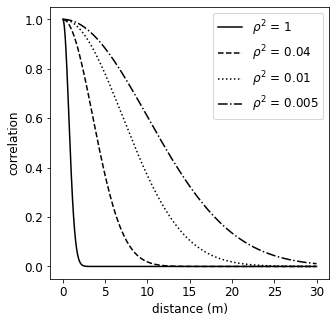

In [260]:
#plotting priors over rhosq
#code adapted from the PyMC repository. Code cell 14.38
#https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb
_, ax = plt.subplots(1, 1, figsize=(5, 5))

xrange = np.linspace(0, 30, 1000)
# squared
ax.plot(xrange, np.exp(-1 * xrange**2), "k", label= r"$\rho^2$ = 1")
ax.plot(xrange, np.exp(-0.04 * xrange**2), "k--", label= r"$\rho^2$ = 0.04")
ax.plot(xrange, np.exp(-0.01 * xrange**2), "k:", label= r"$\rho^2$ = 0.01")
ax.plot(xrange, np.exp(-0.005 * xrange**2), "k-.", label= r"$\rho^2$ = 0.005")

ax.set_xlabel("distance (m)")
ax.set_ylabel("correlation")
plt.legend();

In [261]:
#first we calculate the distance matrix for the cells: 
#the model in this cell is similar to that of McElreath Chapter 14.5
#it's been adapted for a Poisson likelihood 
from scipy.spatial import distance_matrix

#for indexing by cell in the model 
Ncell = df_nona.shape[0]
cell = np.arange(Ncell)

#creating a grid of points in the form [[x,y]]
xx, yy = np.meshgrid(grid_x, grid_y)
points = np.column_stack((xx.ravel(), yy.ravel()))
#keeping only points that aren't nan
points_nonan = np.delete(points, nan_df_indxs, axis = 0)

# Calculate the distance matrix
Dmat = distance_matrix(points_nonan, points_nonan)
Dmatsq = np.power(Dmat, 2)

#spatial model with partial pooling 
with pm.Model() as m3:
    #prior over scale parameter
    a = pm.LogNormal("a", 6, 0.4)
    
    #prior over covariance parameters
    etasq = pm.Exponential("etasq", 2)
    ls_inv = pm.HalfNormal("ls_inv", 2.0) #this accounts for the white noise. specific to pymc implementation 
    rhosq = pm.Deterministic("rhosq", 90 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    #lam is still defined by a log link
    lam = a * pm.math.exp(k[cell])
    
    #the number of kelp in a cell is a Poisson process
    L = pm.Poisson("total_kelp", lam, observed=df_nona['k'])

    trace_m3 = pm.sample(4000, tune=2000, target_accept=0.99)

/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 91 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, etasq, ls_inv, k_rotated_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2529 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,149.813,10.963,129.204,170.325,0.378,0.268,839.0,1656.0,1.01


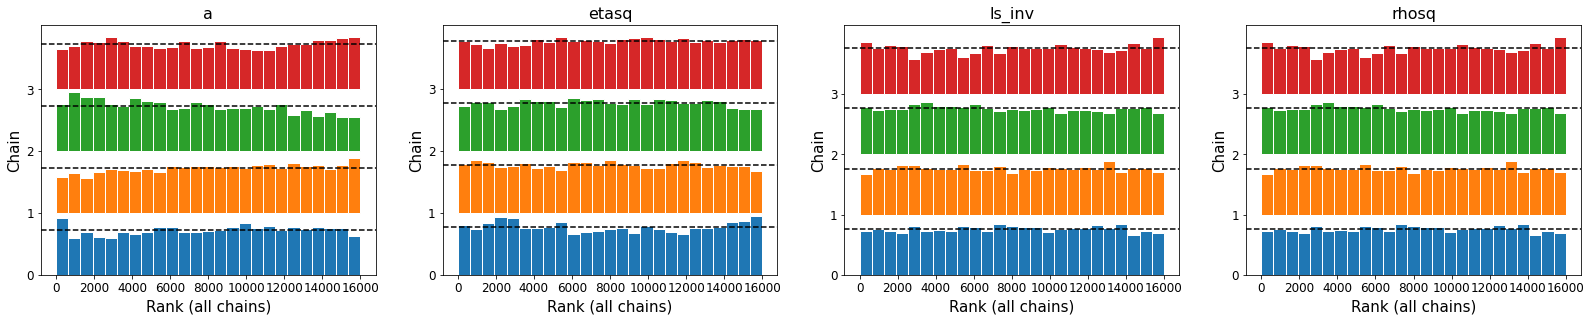

In [286]:
#diagnostics
varnames = ['~k_rotated_','~k']
az.plot_rank(trace_m3, var_names = varnames)
summary = az.summary(trace_m3)
r_hat = summary[summary['r_hat']>1.0]
ess_bulk = summary[summary['ess_bulk']<=800]
ess_tail = summary[summary['ess_tail']<=800]

flagged = pd.concat([r_hat, ess_bulk, ess_tail])
flagged

The diagnostic and summary plots suggest that sampling was done successfully. As there posterior space consists of over 90 parameters, the summary statistics were filtered for potential problems.  With an $\hat{R}$ of 1.01, it seems the sampling for $\alpha$ may be slightly problematic. Inspection of its rank plot reveals general uniformity across the samples, but some chains did under- or overexplore some parts of the posterior. For example, chain 1 spent less time at low ranked points, while chain 2 underexplored high rank values (with chain 3 overexploring them). The ess_bulk is very close to the threshold value, indicative of non-independence of samples. As the scale factor and the parameter that represents the average cell, it is very important to interpolation that estimates of $\alpha$ be accurate. One solution could be to reparametrise the model. Another would be to adjust the acceptance rate. Neither are applied here as the sampling issues do not quite reach the threshold for alarm, however, I acknowledge that there is room for improvement.

array([[<AxesSubplot: ylabel='a'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='etasq'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: ylabel='ls_inv'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: xlabel='a', ylabel='rhosq'>,
        <AxesSubplot: xlabel='etasq'>, <AxesSubplot: xlabel='ls_inv'>,
        <AxesSubplot: xlabel='rhosq'>]], dtype=object)

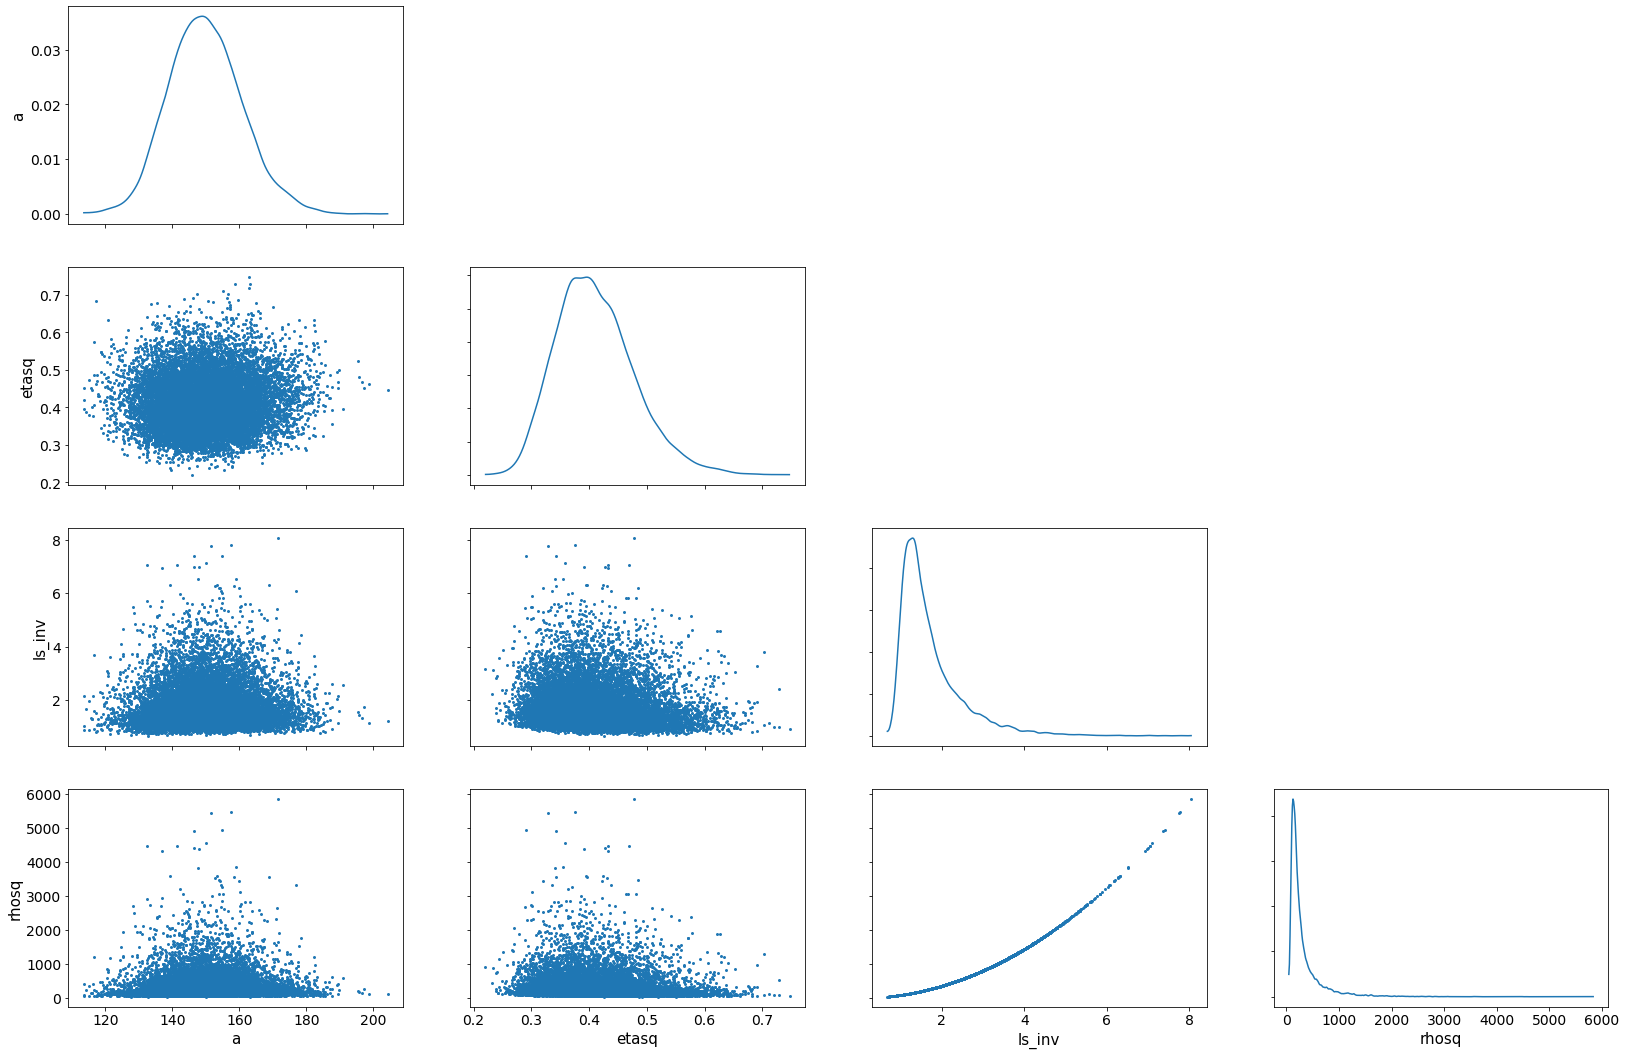

In [263]:
az.plot_pair(trace_m3, var_names = varnames, marginals = True)

The pair plots above reveal why there may have been issues with the sampler - we are dealing with a Devil's Funnel, potentially due to the very high steepness of the marginal posterior over $\rho^2$. Devil's funnels are problematic to a sampler, as any step size that is suitable in one part of the funnel will be unsuitable for another, leaving us unable to properly explore the posterior. We see that the funnel is most problematic for the joint distributions involving $\rho^2$, but that the problem is also evident for ls_inv, our white noise parameter. Note the curved, positive relationship netween ls_inv and $\rho^2$: the faster the decrease in correlation with distance ($\rho^2$), the smaller the white noise too; there is more estimated random noise when cells have stronger spatial correlation. This makes sense as it preserves the between cell variation. The pair plots suggest a need to reparametrise the model - this is recommended for future iterations. 

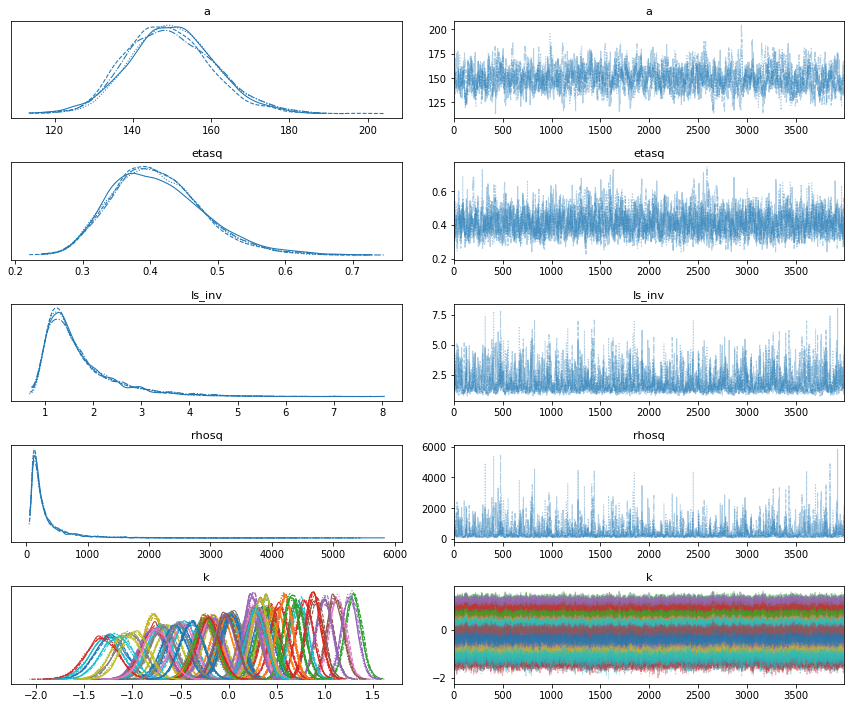

In [269]:
az.plot_trace(trace_m3, var_names=["~k_rotated_"], compact=True)
plt.tight_layout()

Above we have the marginal posteriors over all parameters. Key to focus on is the posterior over $k_i$: we see that the distribution over $k_i$, the varying intercepts, are Gaussian, quite narrow, and span both positive and negative values. This implies that the model is quite confident in the number of kelp in each cell, and also correctly acknowledges that the cells span a wide range of kelp counts. This should give it strong, precise estimating power for an unknown cell. 

Sampling: [total_kelp]


95% confidence interval: [ 42.0 484.0 ]


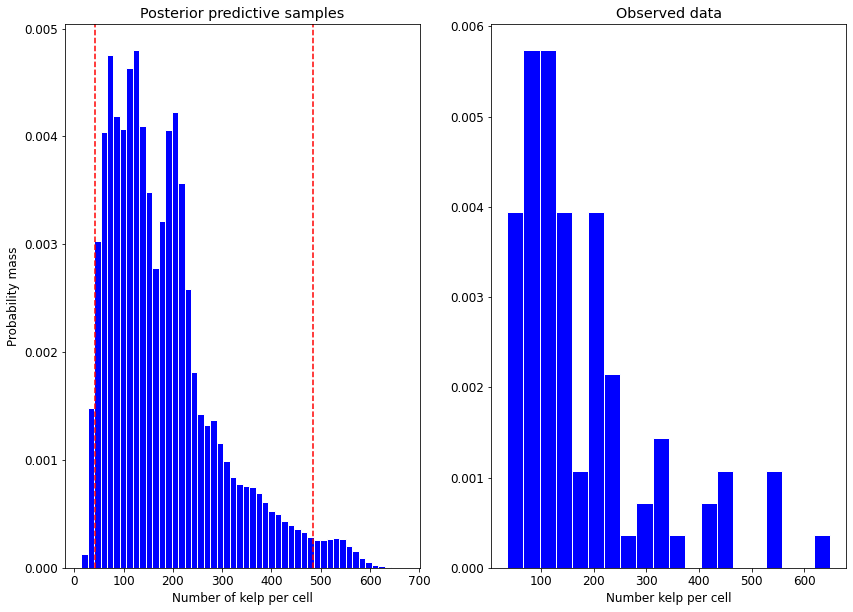

In [265]:
#plotting posterior-predictive
with m3: 
    pm.sample_posterior_predictive(trace_m3, extend_inferencedata = True)
plt.subplots(1,2,figsize = (14,10))
k_pred = trace_m3.posterior_predictive.total_kelp.values.flatten()
CI = np.quantile(k_pred, (0.025, 0.975))
plt.subplot(1,2,1)

print('95% confidence interval: [', CI[0], CI[1], ']')
plt.hist(k_pred, bins = 50, color = 'b', edgecolor = 'white', density = True)
plt.axvline(CI[0], color = 'red', linestyle = '--')
plt.axvline(CI[1], color = 'red', linestyle = '--')
plt.xlabel('Number of kelp per cell')
plt.ylabel('Probability mass')
plt.title('Posterior predictive samples')

plt.subplot(1,2,2)
plt.hist(df_nona.k.values, bins = 20, color = 'b', edgecolor = 'white', density = True)
plt.xlabel('Number kelp per cell')
plt.title('Observed data')
plt.show()


We use the posterior-predictive plot to check the validity of the model. Like m2, m3 provides a much wider 95% confidence interval than m1; the span of plausible values is much broader. We see a similar right skewness as m2, and the posterior-predictive could plausibly predict the data. Despite some of the pitfalls of the posterior and its sampling, the posterior-predictive nonetheless captures the data quite well.

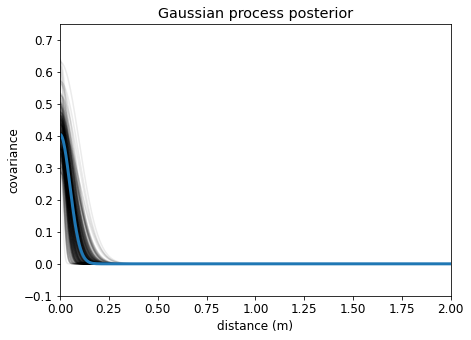

In [287]:
#posterior of covariance parameters 
#code from the pymc resources repository. McElreath 14.41.
# compute posterior median covariance
x_seq = np.linspace(0, 2, 1000)
post = trace_m3.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))
_, ax = plt.subplots(1, 1, figsize=(7, 5))


# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior",
    ylim=(-0.1, 0.75),
    xlim = (0, 2),
    xlabel="distance (m)",
    ylabel="covariance",
);

The posterior over the relationship of covariance with distance tells us that there is little knowledge to be gained by incorporating spatial information. Note that the smallest distance between two cells is 10m (horizontally or vertically adjacent cells). Under the posterior, there is no correlation after just 25cm of distance; even adjacent cells have 0 correlation. This suggests that little value is added by increasing the model complexity (from partial pooling to spatial), and we'll verify this by examining the confidence in predictions next.

In [275]:
#This cell uses the coordinates of the nan value to interpolate
def interpolate_spatial(trace, df):
    #this function returns a list of predictions, one for each unknown cell. 
    copy = df.copy() #we need a copy so that we don't modify the original dataframe
    nan_indxs = copy.loc[pd.isna(copy["k"]), :].index #getting indices of nan cells
    
    
    # computing the distance matrix of the distance of each NaN point to all other points
    distances = distance_matrix(points[nan_indxs], points_nonan)
    
    # substituting those distances into the median covariance function 
    with m3:
        # k is then modeled as a Gaussian process defined by the covariance matrix
        mu = gp.conditional('mu1', Xnew=distances, given=points[nan_indxs, None])
        a = trace.posterior.a.values
        preds = pm.sample_posterior_predictive(trace_m3, var_names= ['mu1'])
        mu_pred = preds.posterior_predictive.mu1.values
    
    lams = np.mean(a) * np.exp(mu_pred) #the link funciton 
    #lams has shape (4,4000,9). We want an array of shape (1,9): one rate for the 9 cells. 
    means = np.mean(lams, axis = (0,1))
    return lams

interpolated_m3_lams = interpolate_spatial(trace_m3, df)
interpolated_m3 = np.mean(interpolated_m3_lams, axis = (0,1))

/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/pymc/gp/gp.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "gp" in given:
/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/pymc/gp/gp.py:202: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if all(val in given for val in ["X", "f"]):
/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 91 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Sampling: [mu1]


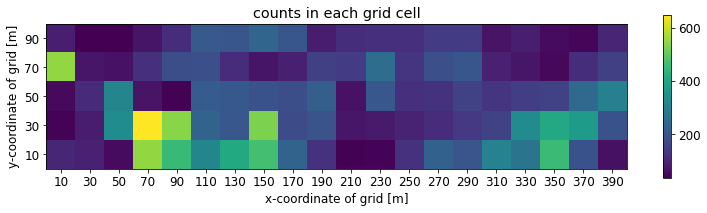

In [276]:
#updating na values

#first we get their indices in the df and data objects 
nan_arr_indxs = np.argwhere(np.isnan(data))
nan_df_indxs = df.loc[pd.isna(df["k"]), :].index

#now we update the nan values in the list using the corresponding inferred value
data_m3_interpolated = data.copy()
for arr_idx, nan_df_indx in zip(nan_arr_indxs, range(0,9)):
    data_m3_interpolated[arr_idx[0],arr_idx[1]] = interpolated_m3[nan_df_indx]
    
#finally generating the plot
plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_m3_interpolated, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

Above are the interpolated values. Though my expectation building this model was to see agreement between the interpolated cells and their adjacent ones, the very steep and sudden decline in correlation with distance given by the posterior reveals that this is not the case, and it's evident in the interpolations made. Consider first the cluster on of high density cells ([70,10],[90,10],[70,30],[90,30]). The interpolated values in [70,50] and [90,50] have very low density, lower than what was predicted by m1 or m2, and lower than you might expect if you assumed this were a high density cluster. Note too the jarring yellow cell in the first column. The spatial model provides surprising interpolations that seem dubious. This model does not seem to predict very well. 


# Model Comparison
4. Show the predictions of the values of each missing cell. Explain the differences between the predictions of the complete pooling and partial pooling models. You will find that one model is more confident (has less variance in its predictions) than the other model. Explain which model we should prefer.


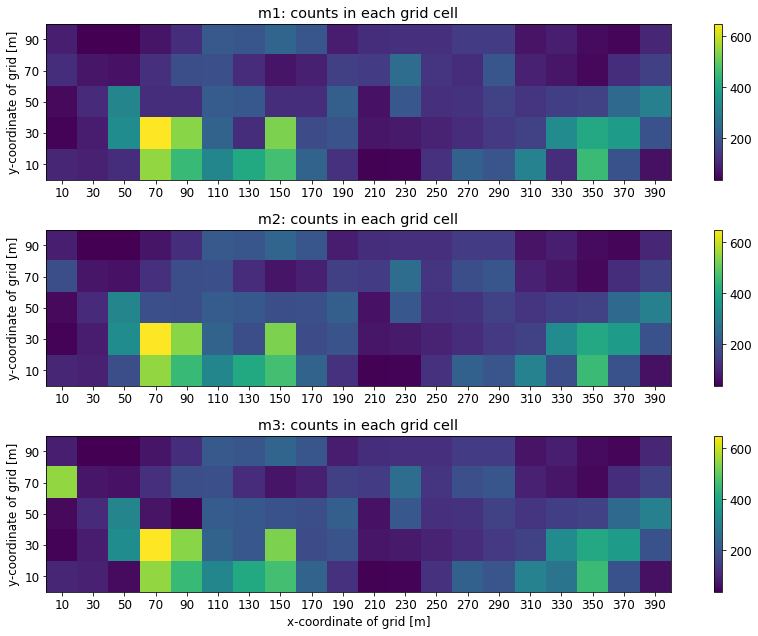

In [277]:
#show the predictions of the values of each missing cell (3 different grids)
plt.subplots(3,1, figsize = (13,9))

plt.subplot(3,1,1)
plt.title('m1: counts in each grid cell')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data_m1_interpolated, origin='lower')
plt.xticks(np.arange(data_m1_interpolated.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_m1_interpolated.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()

plt.subplot(3,1,2)
plt.ylabel('y-coordinate of grid [m]')
plt.title('m2: counts in each grid cell')
plt.imshow(data_m2_interpolated, origin='lower')
plt.xticks(np.arange(data_m2_interpolated.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_m2_interpolated.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()

plt.subplot(3,1,3)
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.title('m3: counts in each grid cell')
plt.imshow(data_m3_interpolated, origin='lower')
plt.xticks(np.arange(data_m3_interpolated.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data_m3_interpolated.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()

plt.tight_layout()
plt.show()

The output above shows the kelp count data as interpolated by each model. All three models interpolated the missing values, often in strong agreement. However, there are some differences to point out. Model 3 has, rather glaringly, predicted that cell [10,70] has ~550 kelp, much more than its neighbours. Both model 2 and model 1 produced more plausible results. Model 3 similarly predicts fewer kelp in cells [70,50] and [90,50] than the other tw models. In general, model 1 predicts that the unfilled cells are similar to the average cell, whereas model 2 allows for more variation between cells and thus provides more varied predictions. This is more realistic than what is assumed by model 1. Model 3 leverages spatial correlations on top of partial pooling, though the role of spatial correlation is minimal (see the discussion on the posterior over the correlation matrix). Some of its interpolations are rather spurious, and m2 appears upon visual inspection the more plausible predictor. 

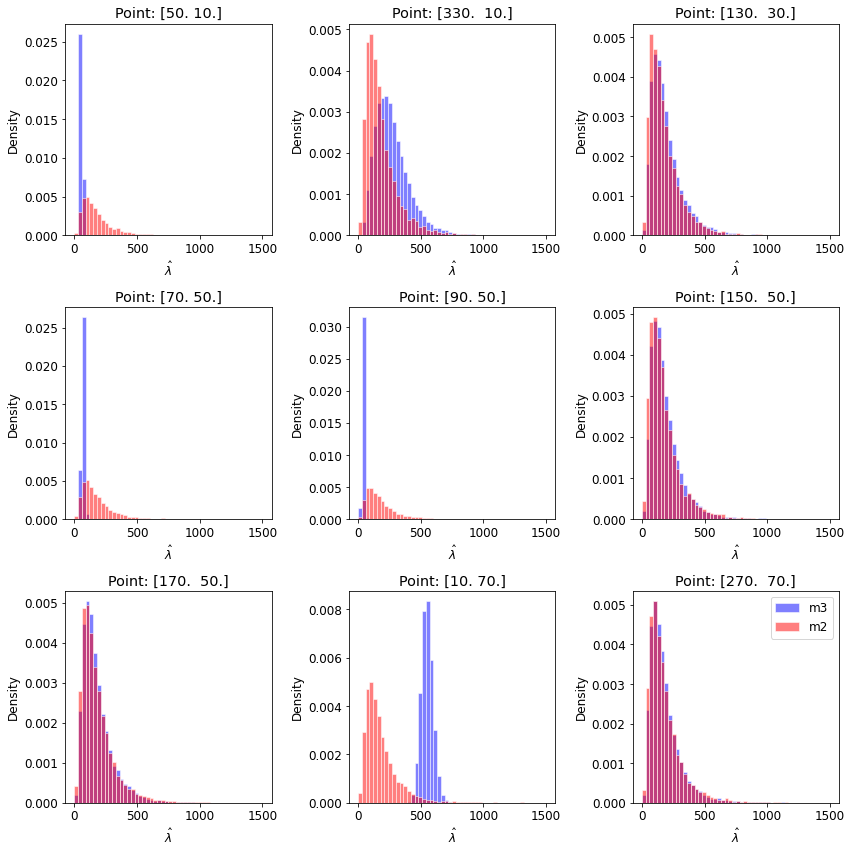

In [339]:

#a (100, 9 array)
lams_full_m1 = trace_m1.posterior.lam.values.flatten()
lams_full_m2 = np.array(interpolated_m2_full)
lams_full_m3 = np.reshape(interpolated_m3_lams, (16000, 9))

plt.subplots(3,3, figsize = (12,12))
# Initialize an empty array to store the selected elements
colors = ['b','orange','g','r','purple','lightgreen','lightblue','forestgreen','pink']
for i in range(0,9):
    plt.subplot(3,3,i+1)
    CI_m3 = np.quantile(lams_full_m3, (0.025,0.975))
    plt.hist(lams_full_m3[:,i], bins = 50, color = 'b', alpha = 0.5,
             edgecolor = 'white', label = 'm3',density = True, range = (0,1500))
    CI_m2 = np.quantile(lams_full_m2, (0.025,0.975))
    plt.hist(lams_full_m2[i], bins = 50, color = 'r', alpha = 0.5, 
             edgecolor = 'white', label = 'm2',density = True, range = (0,1500))
    plt.xlabel('$\hat{\lambda}$')
    plt.ylabel('Density')
    plt.title('Point: '+ str(points[nan_df_indxs[i]]))
plt.tight_layout() 
plt.legend()
plt.show()


Text(0, 0.5, 'Density')

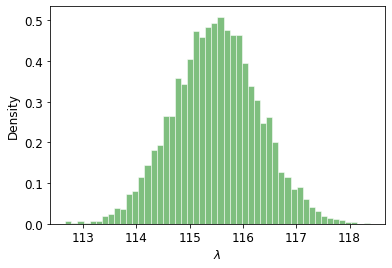

In [208]:
plt.hist(lams_full_m1, bins = 50, color = 'g', alpha = 0.5, 
             edgecolor = 'white', label = 'm2',density = True)
plt.xlabel('$\lambda$')
plt.ylabel('Density')

<ipython-input-365-3d788371ee9a>:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  m3_hdis = az.hdi(lams_full_m3)
<ipython-input-365-3d788371ee9a>:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  m2_hdis = az.hdi(lams_full_m2_transpose)
/Users/finleyjacquin/opt/miniconda3/lib/python3.8/site-packages/arviz/data/base.py:221: UserWarning: More chains (9) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Text(0, 0.5, 'Cell')

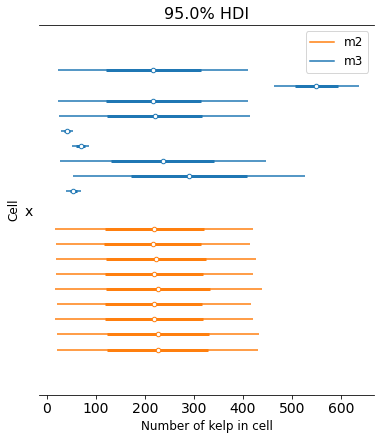

In [365]:
#plot showing the confidence intervals 
m3_hdis = az.hdi(lams_full_m3)
lams_full_m2_transpose = np.transpose(lams_full_m2)
m2_hdis = az.hdi(lams_full_m2_transpose)

az.plot_forest([m3_hdis,m2_hdis], model_names = ['m3','m2'], hdi_prob = 0.95)
plt.xlabel('Number of kelp in cell')
plt.ylabel('Cell')

The three outputs above: the histograms over the inferences in each point, and the forest plot showing the 95% HDI for each inference affirm that m3 is the most confident model. Let me first explain why m1 is the worst model for interpolation. Though the distribution over $\lambda$ for m1 is quite narrow, m1 does not fit the data well in the first place; it doesn't predict cell counts larger than 120, when we see in the data that kelp counts far above this aren't uncommon. So, though it predicts quite confidently, with predictions falling into a narrow interval, it does so too confidently; its interpolations are unlikely to be correct as the span of possible $\lambda$s doesn't accurately reflect the data. 

Comparing m2 and m3, m3 is the more confident model. This is most evident in the forest plot. The 95% HDIs for each unknown point are, at most, as wide under m3 as under m2, and often are much narrower. An explanation for this is that spatial information is being incorporated for some points, thereby giving them much narrower intervals. A look at the histograms shows that m2 and m3 often have very similar posterior-predictives for the interpolated points, but that m3 sometimes provides much narrower estimates. A key difference is at point [270,70], where there is little overlap in the estimate for the point at [10,70]. This could be because m3 generates a varying intercept for the unknown point, whereas m2 interpolates using the population-level hyperparameters. 

# Summary
Three models were used to predict the number of kelp in the unmeasured cells. The first model, m1, used complete pooling; we assumed that the kelp counts were sampled i.i.d. from the same underlying distribution, and it's that underlying distribution that we use the data to estimate. m1 poorly predicted the data and offered very conservative and uniform estimates of the unknown points. Partial pooling with m2 offered a significant improvement over m1: the data could be plausibly approximated from the m2 posterior-predictive. Predictions under m2 were less confident, spanning a wider range of values, but this also offers more realistic interpolations; the missing kelp counts are unlikely to just be the mean of all cells, and model 2 does better in providing varied predictions. Model 3 aimed to incorporate spatial correlation. Though the posterior over that correlation showed that there was very little of it, m3 provides estimates that are at least as confident as m2. As m3 suffers from some sampling errors, its inferences are unreliable, despite being precise. Thus m2 is the best model for interpolation, though a reparametrised m3 could offer an improvement. 

# Use of AI Tools
I referred to Statistical Rethinking (McElreath) and the PyMC Resources repository to view the McElreath code in Python. Where code from the repository has been used / adapted, I've made not of that in the first line of the relevant code cell. I used ChatGPT to try to debug code, but it produced unecessarily complex solutions and was rather unhelpful. No code in this assignment was written by an AI tool.